In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Train the ML model
# from models import EncoderSingle, EncoderMulti
from utils import sample_files, load_encoder_data, plot_loss
from utils import encoder_files_to_tensors, fast_tensor_load

import time
import glob
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
from datetime import datetime
import argparse
import matplotlib.pyplot as plt
import matplotlib as mpl



2023-09-12 10:26:24.687757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 10:26:31.219065: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-12 10:26:31.880195: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-09-12 10:26:31

In [6]:
data_dir = './tomo_data/datasets_encoder_TF_24-03-23'

timestamp = datetime.now().strftime("%Y_%m_%d_%H-%M-%S")
print('Using timestamp: ', timestamp)

IMG_OUTPUT_SIZE = 128
DATA_LOAD_METHOD='FAST_TENSOR' # it can be TENSOR or DATASET or FAST_TENSOR
num_Turns_Case = 1
var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']



Using timestamp:  2023_09_12_10-28-28


In [10]:
# Data specific

# Train specific
train_cfg = {
    'epochs': 10,
    'dense_layers': [64],
    'filters': [8, 16],
    'cropping': [0, 0],
    'kernel_size': 7,
    'strides': [2, 2],
    'activation': 'relu',
    'pooling': None,
    'pooling_size': [0, 0],
    'pooling_strides': [1, 1],
    'pooling_padding': 'valid',
    'dropout': 0.1,
    'loss': 'mse',
    'lr': 1e-3,
    'dataset%': 1,
    'normalization': 'minmax',
    'img_normalize': 'off'
}


In [11]:
# Initialize GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
device_to_use = 0

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(
            logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('No GPU available, using the CPU')


trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
assert os.path.exists(ML_dir)

TRAINING_PATH = os.path.join(ML_dir, 'TRAINING')
VALIDATION_PATH = os.path.join(ML_dir, 'VALIDATION')

# create the directory to store the results
os.makedirs(trial_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)


assert train_cfg['normalization'] == 'minmax'
assert train_cfg['img_normalize'] == 'off'

TRAINING_PATH = os.path.join(ML_dir, 'training-??.npz')
VALIDATION_PATH = os.path.join(ML_dir, 'validation-??.npz')

start_t = time.time()

x_train, y_train = fast_tensor_load(TRAINING_PATH, train_cfg['dataset%'])
print('Number of Training files: ', len(y_train))

x_valid, y_valid = fast_tensor_load(VALIDATION_PATH, train_cfg['dataset%'])
print('Number of Validation files: ', len(y_valid))


print(
    f'\n---- Input files have been read, elapsed: {time.time() - start_t} ----\n')


No GPU available, using the CPU
Loading ./tomo_data/datasets_encoder_TF_24-03-23/ML_data/training-00.npz


2023-09-12 10:31:47.207086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of Training files:  15898
Loading ./tomo_data/datasets_encoder_TF_24-03-23/ML_data/validation-00.npz
Number of Validation files:  1404


In [ ]:
# start_t = time.time()
# # Create the datasets
# # 1. Randomly select the training data
# file_names = sample_files(TRAINING_PATH, train_cfg['dataset%'], keep_every=num_Turns_Case)
# print('Number of Training files: ', len(file_names))

# # 2. Convert to tensor dataset
# train_dataset = tf.data.Dataset.from_tensor_slices(file_names)

# # 3. Then map function to dataset
# # this returns pairs of tensors with shape (128, 128, 1) and (7,)
# train_dataset = train_dataset.map(lambda x: tf.py_function(
#     load_encoder_data,
#     [x, train_cfg['normalization'], True],
#     [tf.float32, tf.float32]))

# # 4. Ignore errors in case they appear
# train_dataset = train_dataset.apply(
#     tf.data.experimental.ignore_errors())

# # Repeat for validation data
# file_names = sample_files(
#     VALIDATION_PATH, train_cfg['dataset%'], keep_every=num_Turns_Case)
# print('Number of Validation files: ', len(file_names))

# # convert to dataset
# valid_dataset = tf.data.Dataset.from_tensor_slices(file_names)
# # Then map function to dataset
# # this returns pairs of tensors with shape (128, 128, 1) and (7,)
# valid_dataset = valid_dataset.map(lambda x: tf.py_function(
#     load_encoder_data,
#     [x, train_cfg['normalization'], True],
#     [tf.float32, tf.float32]))
# # Ignore errors
# valid_dataset = valid_dataset.apply(
#     tf.data.experimental.ignore_errors())

# end_t = time.time()
# print(
#     f'\n---- Input files have been read, elapsed: {end_t - start_t} ----\n')

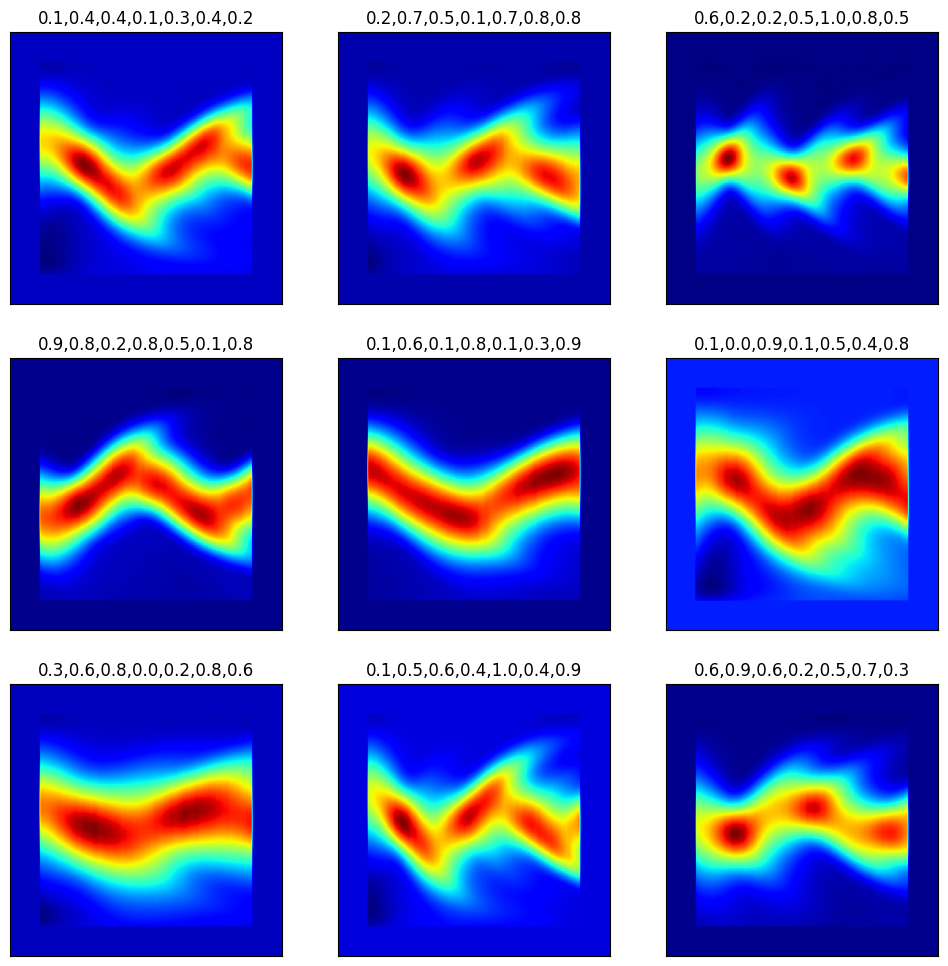

In [12]:
%matplotlib inline
# plot some of the outputs

nrows = 3
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(x_train)),
                          size=nrows * nrows, replace=False)

samples_X = tf.gather(x_train, sample)
samples_y = tf.gather(y_train, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
for i in range(len(axes)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    title = ','.join([f'{num:.1f}' for num in samples_y[i]])
    ax.set_title(f'{title}')


In [ ]:
class EncoderSingle(keras.Model):
    # Pooling can be None, or 'Average' or 'Max'
    def __init__(self, output_name, input_shape=(128, 128, 1), dense_layers=[1024, 256, 64],
                 filters=[8, 16, 32], cropping=[[0, 0], [0, 0]], kernel_size=3,
                 strides=[2, 2], activation='relu',
                 pooling=None, pooling_size=[2, 2],
                 pooling_strides=[1, 1], pooling_padding='valid',
                 dropout=0.0, learning_rate=0.001, loss='mse',
                 metrics=[], use_bias=True, batchnorm=False,
                 conv_padding='valid', **kwargs):
        super().__init__()

        self.output_name = output_name
        self.inputShape = input_shape
        # the kernel_size can be a single int or a list of ints
        if isinstance(kernel_size, int):
            kernel_size = [kernel_size] * len(filters)
        assert len(kernel_size) == len(filters)

        # the strides can be a list of two ints, or a list of two-int lists
        if isinstance(strides[0], int):
            strides = [strides for _ in filters]
        assert len(strides) == len(filters)

        # set the input size
        inputs = keras.Input(shape=input_shape, name='Input')
        # crop the edges
        cropped = keras.layers.Cropping2D(
            cropping=cropping, name='Crop')(inputs)
        x = cropped
        # For evey Convolutional layer
        for i, f in enumerate(filters):
            # Add the Convolution
            x = keras.layers.Conv2D(
                filters=f, kernel_size=kernel_size[i], strides=strides[i],
                use_bias=use_bias, padding=conv_padding,
                name=f'{output_name}_CNN_{i+1}')(x)

            # Apply batchnormalization
            if batchnorm:
                x = tf.keras.layers.BatchNormalization()(x)

            # Apply the activation function
            x = keras.activations.get(activation)(x)

            # Optional pooling after the convolution
            if pooling == 'Max':
                x = keras.layers.MaxPooling2D(
                    pool_size=pooling_size, strides=pooling_strides,
                    padding=pooling_padding, name=f'{output_name}_MaxPooling_{i+1}')(x)
            elif pooling == 'Average':
                x = keras.layers.AveragePooling2D(
                    pool_size=pooling_size, strides=pooling_strides,
                    padding=pooling_padding, name=f'{output_name}_AveragePooling_{i+1}')(x)

        # Flatten after the convolutions
        x = keras.layers.Flatten(name=f'{output_name}_Flatten')(x)
        # For each optional dense layer
        for i, layer in enumerate(dense_layers):
            # Add the layer
            x = keras.layers.Dense(layer, activation=activation,
                                   name=f'{output_name}_Dense_{i+1}')(x)
            # Add dropout optionally
            if dropout > 0 and dropout < 1:
                x = keras.layers.Dropout(
                    dropout, name=f'{output_name}_Dropout_{i+1}')(x)

        # Add the final layers, one for each output
        outputs = keras.layers.Dense(1, name=output_name)(x)

        # Also initialize the optimizer and compile the model
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        self.model = model

    def predict(self, waterfall):
        latent = self.model(waterfall)
        return latent

    def load(self, weights_file):
        self.model = keras.models.load_model(weights_file)

    def save(self, weights_file):
        self.model.save(weights_file)

In [ ]:

# Train specific
train_cfg = {
    'epochs': 10,
    'dense_layers': [16],
    'filters': [8],
    'cropping': [0, 0],
    'kernel_size': 7,
    'strides': [2, 2],
    'activation': 'relu',
    'pooling': None,
    'pooling_size': [0, 0],
    'pooling_strides': [1, 1],
    'pooling_padding': 'valid',
    'dropout': 0.1,
    'loss': 'mse',
    'lr': 1e-3,
    'dataset%': 1,
    'normalization': 'minmax',
    'loss_weights': [2],
    'batch_size': 32
}

model_cfg = {
    'bl': {
        'epochs': 100,
        'cropping': [12, 12],
        'filters': [8, 16, 32],
        'kernel_size': [(13, 3), (7, 3), (3, 3)],
        'strides': [2, 2],
        'dense_layers': [1024, 512, 128],
        'activation': 'relu',
        'pooling': None,
        'dropout': 0.,
        'lr': 1e-3,
        'normalization': 'minmax',
        'batch_size': 32
    },
}


output_names = np.array(var_names)[train_cfg['loss_weights']]
print(output_names)

# Model instantiation
start_t = time.time()
input_shape = (IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE, 1)
models = {}

for i in train_cfg['loss_weights']:
    var_name = var_names[i]
    print(f'\n---- Initializing model: {var_name} ----\n')

    cfg = train_cfg.copy()
    cfg.update(model_cfg.get(var_name, {}))
    model_cfg[var_name] = cfg
    
    model = EncoderSingle(output_name=var_name,
                          input_shape=input_shape,
                         **cfg)
    print(model.model.summary())

    models[var_name] = {'model': model.model,
                        'train': tf.gather(y_train, i, axis=1),
                        'valid': tf.gather(y_valid, i, axis=1)}
print(
    f'\n---- Models have been initialized, elapsed: {time.time() - start_t} ----\n')


# Train the encoder
historyMulti = {}

for var_name in models:
    model = models[var_name]['model']
    cfg = model_cfg[var_name]
    # Train the encoder
    print(f'\n---- {var_name}: Training the encoder ----\n')

    start_time = time.time()

    # callbacks, save the best model, and early stop if no improvement in val_loss
    stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=10, restore_best_weights=True)
    save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'encoder_{var_name}.h5'),
                                                monitor='val_loss', save_best_only=True)

    history = model.fit(
        x=x_train, y=models[var_name]['train'], 
        epochs=cfg['epochs'],
        validation_data=(x_valid, models[var_name]['valid']),
        callbacks=[save_best], 
        batch_size=cfg['batch_size'],
        verbose=0)
    historyMulti[f'{var_name}_loss'] = history.history['loss']
    historyMulti[f'{var_name}_val_loss'] = history.history['val_loss']

    total_time = time.time() - start_time
    print(
        f'\n---- {var_name}: Training complete, epochs: {len(history.history["loss"])}, train loss {np.min(history.history["loss"]):.2e}, valid loss {np.min(history.history["val_loss"]):.2e}, total time {total_time} ----\n')


In [ ]:
%matplotlib inline
train_loss_l = []
valid_loss_l = []
for k, v in historyMulti.items():
    if 'val' in k:
        valid_loss_l.append(v)
    else:
        train_loss_l.append(v)

train_loss_l = np.mean(train_loss_l, axis=0)
valid_loss_l = np.mean(valid_loss_l, axis=0)
print(train_loss_l)
plot_loss({'training': train_loss_l, 'validation': valid_loss_l},
          title='Encoder Train/Validation Loss')

plot_loss(historyMulti, title='Encoder loss per output')

print(historyMulti)


In [ ]:
# Model instantiation
input_shape = (IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE, 1)
train_cfg['loss_weights'] = [0, 1, 2, 3, 4, 5, 6]

output_names = np.array(var_names)[train_cfg['loss_weights']]
print(output_names)

encoderMulti = EncoderMulti(input_shape=input_shape,
                            output_names=output_names, **train_cfg)
models = {}
for i in train_cfg['loss_weights']:
    var_name = var_names[i]
    models[var_name] = {'model': encoderMulti.models[var_name],
                        'train': train_dataset.map(lambda x, y: (x, y[i])).batch(1),
                        'valid': valid_dataset.map(lambda x, y: (x, y[i])).batch(1)}
    print(models[var_name]['model'].summary())

# Train the encoder
historyMulti = {}

for var_name in models:
    model = models[var_name]['model']

    # Train the encoder

    print(f'\n---- {var_name}: Training the encoder ----\n')

    start_time = time.time()

    # callbacks, save the best model, and early stop if no improvement in val_loss
    stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=5, restore_best_weights=True)
    save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'encoder_{var_name}.h5'),
                                                monitor='val_loss', save_best_only=True)

    history = model.fit(
        models[var_name]['train'], epochs=train_cfg['epochs'],
        validation_data=models[var_name]['valid'],
        callbacks=[stop_early, save_best],
        verbose=0)
    historyMulti[f'{var_name}_loss'] = history.history['loss']
    historyMulti[f'{var_name}_val_loss'] = history.history['val_loss']

    total_time = time.time() - start_time
    print(
        f'\n---- {var_name}: Training complete, epochs: {len(history.history["loss"])}, min loss {np.min(history.history["val_loss"])}, total time {total_time} ----\n')


In [ ]:
%matplotlib inline
train_loss_l = []
valid_loss_l = []
for k, v in historyMulti.items():
    if 'val' in k:
        valid_loss_l.append(v)
    else:
        train_loss_l.append(v)

train_loss_l = np.mean(train_loss_l, axis=0)
valid_loss_l = np.mean(valid_loss_l, axis=0)
print(train_loss_l)
plot_loss({'training': train_loss_l, 'validation': valid_loss_l},
            title='Encoder Train/Validation Loss')

plot_loss(historyMulti, title='Encoder loss per output')

print(historyMulti)

In [ ]:
from models import Encoder
# Model instantiation

input_shape = (IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE, 1)

encoder = Encoder(input_shape=input_shape, **train_cfg)

print(encoder.model.summary())

# Train the encoder

# callbacks, save the best model, and early stop if no improvement in val_loss
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, 'encoder.h5'),
                                            monitor='val_loss', save_best_only=True)


start_time = time.time()
# history = encoder.model.fit(
#     train_dataset, epochs=train_cfg['epochs'],
#     validation_data=valid_dataset,
#     callbacks=[stop_early, save_best])
history = encoder.model.fit(
    x_train, y_train, epochs=train_cfg['epochs'],
    validation_data=(x_valid, y_valid),
    batch_size=BATCH_SIZE,
    callbacks=[stop_early, save_best])

total_time = time.time() - start_time


In [ ]:
print(history.history)

print(historyFunc.history)

In [ ]:
total = []
val_total = []
for k, v in history.history.items():
    if k != 'loss' and 'val' not in k:
        total.append(v)
    if k != 'val_loss' and 'val' in k:
        val_total.append(v)
    
total = np.array(total)
val_total = np.array(val_total)

weights = np.array(train_cfg['loss_weights']).reshape(-1, 1)
print('Mean:', np.sum(total*weights, axis=0)/np.sum(weights))
history.history['loss'] = np.sum(total*weights, axis=0)/np.sum(weights)
history.history['val_loss'] = np.sum(val_total*weights, axis=0)/np.sum(weights)


In [ ]:
%matplotlib widget
def plot_loss(lines, title='', figname=None):
    plt.figure()
    plt.title(title)
    for line in lines.keys():
        if 'val' in line:
            marker='x'
        else:
            marker='.'
        plt.semilogy(lines[line], marker=marker, label=line)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(ncol=2)
    plt.tight_layout()
    # if figname:
    #     plt.savefig(figname, dpi=300)
    # plt.close()

plot_loss(history.history)

train_loss_l = np.array(history.history['loss'])
valid_loss_l = np.array(history.history['val_loss'])

plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
          title='Encoder Train/Validation Loss')


In [ ]:
from sklearn.metrics import mean_absolute_error

from functools import partial


def my_mse(y_true, y_pred):
    return tf.reduce_mean(tf.math.abs(y_pred - y_true), axis=0)


y_true = np.array([[0., 0.], [1., 1.]])
y_pred = np.array([[1., 0.5], [2., 1.5]])
loss = keras.losses.mean_absolute_error(y_true, y_pred)
mae2 = MyMeanAbsoluteError(reduction=keras.losses.Reduction.NONE)
mae = keras.losses.MeanAbsoluteError(reduction=keras.losses.Reduction.NONE)
lossv2 = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
# lossv3 = my_mse(1, y_true, y_pred)
# print(loss)
# print(mae(y_true, y_pred).numpy())
print(lossv2)
# print(mae2(y_true, y_pred).numpy())
# lossv4 = my_mse(y_true, y_pred)

print(my_mse(y_true, y_pred))
# print(my_mse(1, y_true, y_pred))


In [ ]:
# Plot training and validation loss
train_loss_l = np.array(history.history['loss'])
valid_loss_l = np.array(history.history['val_loss'])

plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
          title='Encoder Train/Validation Loss',
          figname=os.path.join(plots_dir, 'encoder_train_valid_loss.png'))


In [ ]:
from sklearn.metrics import mean_squared_error

# get predictions
y_pred = encoder.model.predict(x_valid, verbose=False)
y_pred = np.array(y_pred)
y_valid = np.array(y_valid)

# Calculate error per variable
mses = mean_squared_error(y_valid, y_pred, multioutput='raw_values')

var_names = ['phase_error', 'energy_error',
             'bunch_length', 'intensity', 'Volt_rf', 'mu', 'Vrf_SPS']
# report
print('Variable\tMSE')
for name, mse in zip(var_names, mses):
    print(f'{name}:\t{mse:.4f}')


In [ ]:
from sklearn.metrics import mean_squared_error

# get predictions
y_pred = encoderFunc.model.predict(x_valid, verbose=False)
y_pred = np.array(y_pred).reshape(7, -1).T
y_valid = np.array(y_valid)
# Calculate error per variable
mses = mean_squared_error(y_valid, y_pred, multioutput='raw_values')
print(mses.shape)
var_names = ['phase_error', 'energy_error',
             'bunch_length', 'intensity', 'Volt_rf', 'mu', 'Vrf_SPS']
# report
print('Variable\tMSE')
for name, mse in zip(var_names, mses):
    print(f'{name}:\t{mse:.4f}')


In [ ]:
# save file with experiment configuration
config_dict = {}
config_dict['encoder'] = train_cfg.copy()
config_dict['encoder'].update({
    'min_train_loss': float(np.min(train_loss_l)),
    'min_valid_loss': float(np.min(valid_loss_l)),
    'total_train_time': total_time,
    'used_gpus': len(gpus)
})

# save config_dict
with open(os.path.join(trial_dir, 'encoder-summary.yml'), 'w') as configfile:
    yaml.dump(config_dict, configfile, default_flow_style=False)
